# Token and Transformer

In this file, we will train a transformer model to generate images autoregressively at the pixel level, which means the model will predict one pixel at a time in a preconfigured order ([raster scan order](https://en.wikipedia.org/wiki/Raster_scan#:~:text=Scan%20lines,-In%20a%20raster&text=This%20ordering%20of%20pixels%20by,continuously%20over%20the%20scan%20line)). Like previous assignments, we will train our model on the MNIST dataset.


The file is broken up as follows:

  1. [Question 1: Tokenization (1.5 points)](#1)  
  1. [Question 2: Transformer Implementation (1.5 points)](#2)  
  1. [Question 3: Transformer Training (2.5 points)](#3)  
  1. [Question 4: Transformer Inference (2.5 points)](#4)  
  1. [Question 5: Image Completions (2 points)](#5)  

## Setup

If you do not have access to a CUDA-compatible NVIDIA GPU, it is recommended that you run this notebook in [Google Colab](https://colab.research.google.com/). There, you will have the option to enable GPU acceleration with `Runtime` >> `Change runtime type` >> `Hardware accelerator` >> `GPU` >> `Save`. Note that you may have to re-connect or restart the notebook after changing runtime types.

In [ ]:
# helper code from the course repository
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
# install common pacakges used for deep learning
!cd course-deep-learning && pip install -r requirements.txt

Cloning into 'course-deep-learning'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 575 (delta 15), reused 19 (delta 8), pack-reused 547 (from 1)
Receiving objects: 100% (575/575), 146.09 MiB | 48.25 MiB/s, done.
Resolving deltas: 100% (303/303), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   

In [ ]:
%matplotlib inline
%cd course-deep-learning/

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.adversarial_examples import *

/content/course-deep-learning


----
## <a name="1">Question 1: Tokenization (1.5 points total)</a>

Recall that autoregressive language models typically predict a sequence of discrete (integer) tokens from a fixed vocabulary. At first glance, image data lacks this discrete sequential structure and therefore seems like a poor candidate for language modeling.

However, there are in fact many ways to represent an image as a sequence of discrete tokens. [State-of-the art approaches](https://arxiv.org/abs/2404.02905) often leverage large neural network-based autoencoders, but we'll keep things as simple as possible: first, we will "flatten" an image into a one-dimensional vector of pixels, and then we will treat each pixel as a token by rounding its continuous intensity value to one of a few discrete values. To do this, we can divide the observed range of intensities into bins, and represent a pixel's intensity through its bin index. This is the approach we'll be taking.

We will implement a `Tokenizer` object that converts image data into tokens. This object-oriented approach mimics the tokenizer abstraction found in most language modeling repositories, across modalities from text to audio to images.


### 1.1: Implementing Tokenization

**YOUR TASK (1 point)**: Fill in the commented parts of the code below to tokenize 2D images with continuous values into 1D sequences of discrete tokens. Your code should divide the observed range of intensity values into equal-width bins that uniformly cover the observed range, and you should set your bins using the MNIST _validation_ dataset.

### 1.2: Tokenization Results

**YOUR TASK (0.5 points)**: After tokenizing the MNIST _training_ dataset, plot a histogram of the most common tokens by iterating through every image and counting the number of times each token appears. Matplotlib may cause your notebook kernel error to out when trying to create a very large histogram, so use the first 1,000,000 tokens.

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.50MB/s]


Min pixel value: -1.0, Max pixel value: 1.0
Bins tensor([-0.8750, -0.7500, -0.6250, -0.5000, -0.3750, -0.2500, -0.1250,  0.0000,
         0.1250,  0.2500,  0.3750,  0.5000,  0.6250,  0.7500,  0.8750])


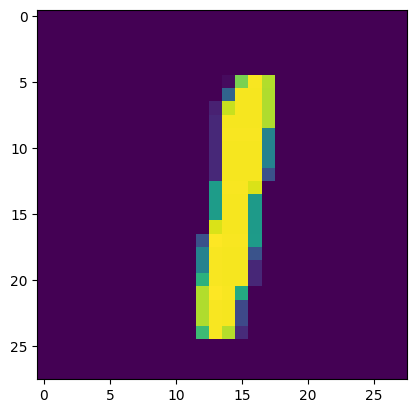

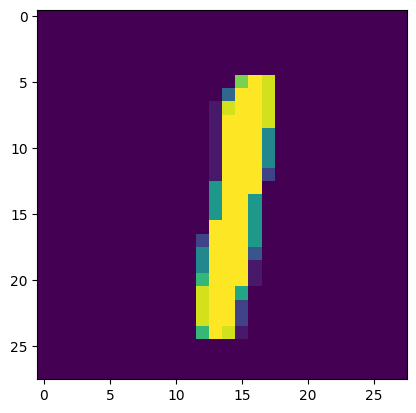

Example tokenized image tensor
tensor([[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12, 15,
          14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 15, 15,
          14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0, 

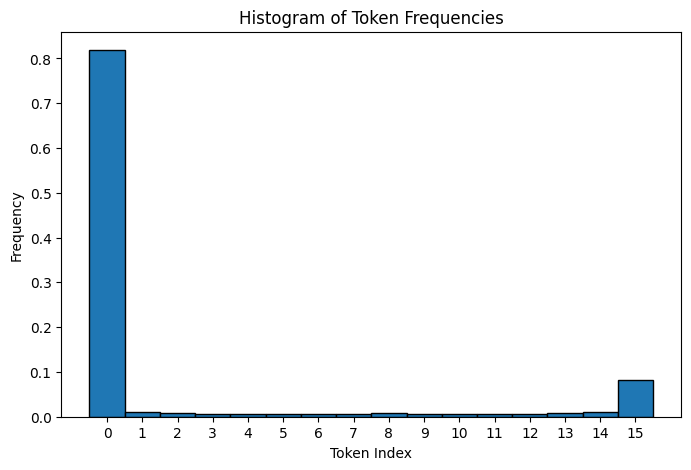

In [ ]:
class Tokenizer(torch.nn.Module):

  def __init__(
    self,
    n_channels: int = 1,  # MNIST digits are grayscale so there is only 1 channel
    image_size: int = 28, # MNIST digits are 28 by 28, so this is really image_height and image_width.
    vocab_size: int = 16  # This is the number of quantization bins we'll be using when we tokenize
  ):
    super().__init__()

    self.n_channels = n_channels
    self.image_size = image_size
    self.vocab_size = vocab_size

    self.initialized = False

    self.bins = None

  def initialize(self, images: list):
    """
    Initializes the tokenizer by computing equal-width bins using the MNIST validation dataset.
    """

    # Convert list of tensors to a single tensor
    images_tensor = torch.cat(images, dim=0)  # (n_total_images, 1, 28, 28)

    ########################################
    # YOUR CODE HERE: Compute min and max intensity values
    ########################################
    min_val, max_val = images_tensor.min().item(), images_tensor.max().item()
    print(f"Min pixel value: {min_val}, Max pixel value: {max_val}")

    ########################################
    # YOUR CODE HERE: Create `vocab_size` equally spaced bins from min_val to max_val
    ########################################
    self.bins = torch.linspace(min_val, max_val, steps=self.vocab_size + 1)[1:-1]  # Exclude first/last for bin edges

    self.initialized = True



  # def forward(self, x: torch.Tensor):

  #   if not self.initialized:
  #     raise RuntimeError(
  #       f"Tokenizer not initialized! Must call `.initialize()` "
  #       f"on a list of image tensors to set bins first"
  #     )

  #   assert x.ndim == 4  # (n_batch, n_channels, image_size, image_size)
  #   assert x.shape[1] == self.n_channels
  #   assert x.shape[2] == x.shape[3] == self.image_size

  #   # flatten image into pixel sequence
  #   x_flat = x.reshape(x.shape[0], -1)  # (n_batch, n_channels * image_size * image_size)

  #   ########################################
  #   # YOUR CODE HERE: apply tokenization by replacing
  #   # each pixel value in `x_flat` with the
  #   # integer index of the nearest intensity
  #   # bin in `self.bins`. The resulting
  #   # tensor should be of dtype `torch.long`
  #   # and have the same shape as `x_flat`


  #   ########################################

  #   x_tokenized = torch.bucketize(x_flat, self.bins)  # Convert to bin indices
  #   x_tokenized = x_tokenized.long()  # Ensure it's an integer type

  #   return x_tokenized  # (n_batch, n_channels * image_size * image_size)
  def forward(self, x: torch.Tensor):
    if not self.initialized:
        raise RuntimeError("Tokenizer must be initialized first.")

    x_flat = x.reshape(x.shape[0], -1)

    # **Force Background Pixels to Token 0**
    background_threshold = self.bins[0]  # Smallest bin value
    x_flat[x_flat <= background_threshold] = background_threshold

    x_tokenized = torch.bucketize(x_flat, self.bins)
    return x_tokenized.long()



torch.manual_seed(0)  # fix random seed

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# download MNIST data
# mnist_train, mnist_test = load_mnist()

# Load MNIST dataset
def load_mnist():
    from torchvision import datasets, transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

    return train_loader, test_loader

mnist_train, mnist_test = load_mnist()

tokenizer = Tokenizer(n_channels=1, image_size=28, vocab_size=16)

# loop over a few batches to estimate bins
images = []
for batch in mnist_test:
  x, _ = batch
  images += [x]

images = torch.cat(images, dim=0)
images = [images[i:i+1] for i in range(images.shape[0])]

tokenizer.initialize(images)

print("Bins", tokenizer.bins)

# plot an example image before and after tokenization,
# accounting for the fact that our tokenizer "flattens"
# images
plt.imshow(x[0][0])
plt.show()

x_tok = tokenizer(x)
x_tok = x_tok.reshape(-1, 1, 28, 28)
plt.imshow(x_tok[0][0])
plt.show()

print("Example tokenized image tensor")
print(x_tok[0])


########################################
# YOUR CODE HERE: Write the code to make the
# histogram of token frequencies
########################################
all_tokens = []
for batch in mnist_train:
    x, _ = batch
    x_tok = tokenizer(x)
    all_tokens.extend(x_tok.flatten().tolist())

    if len(all_tokens) > 1_000_000:  # Limit histogram to first 1M tokens
        break

all_tokens = np.array(all_tokens[:1_000_000])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_tokens, bins=np.arange(17) - 0.5, density=True, edgecolor="black")
plt.xticks(range(16))
plt.xlabel("Token Index")
plt.ylabel("Frequency")
plt.title("Histogram of Token Frequencies")
plt.show()

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR HISTOGRAM HERE)</div>
</center>

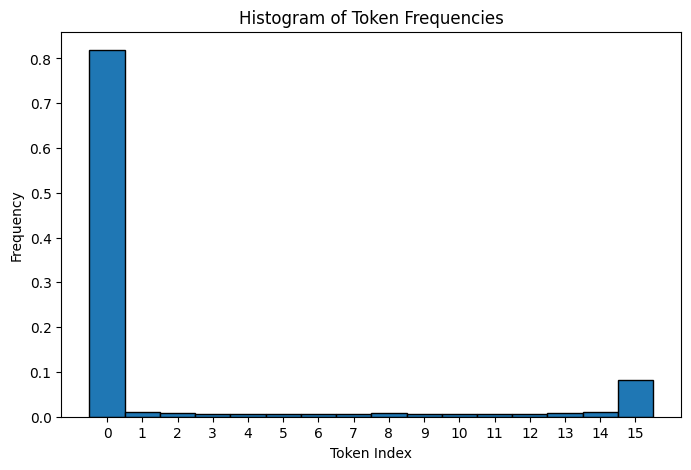


## <a name="2">Question 2: Transformer Implementation (1.5 points total)</a>

Next, we’ll build our transformer architecture. We will implement a _decoder-only_ (_GPT-style_) transformer model that takes a sequence of image tokens as input and outputs a probability distribution for what the next token in the sequence will be.

Here are some useful general resources when working with transformers; note that these articles describe _encoder-decoder_ transformers, which differ slightly from the model we will be implementing:
* Jay Alammar’s [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)  
* [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)  
* [The Original Transformer Paper](https://arxiv.org/pdf/1706.03762)  

This article focuses on the decoder-only transformer architecture that we'll be using:
* [Decoder-Only Transformers](https://cameronrwolfe.substack.com/p/decoder-only-transformers-the-workhorse)

We've defined most of the architecture for you below. However, we've omitted one key part: _the self-attention mechanism_. The articles linked above discuss how this mechanism works in detail.


**YOUR TASK (1.5 points)**: Fill in the commented part of the `MHSA` class code below according to the instructions. You can test your implementation by running the cell below.

In [ ]:
class MLP(torch.nn.Module):
  """
  The MLP block within a transformer layer. Can be thought to "mix" the outputs
  of multiple attention heads at each sequence position, without mixing
  information from across separate sequence positions.
  """

  def __init__(
    self,
    model_dim: int,          # the model's internal "dimension" or "hidden size"
    mult: int = 4,           # the number of times bigger the MLP's hidden dimension will be than "model_dim"
    p_dropout: float = 0.1,  # probability of random dropout
  ):

    super().__init__()

    self.mlp = torch.nn.Sequential(
      torch.nn.Linear(model_dim, model_dim * mult),
      torch.nn.Dropout(p_dropout),
      torch.nn.GELU(),
      torch.nn.Linear(model_dim * mult, model_dim),
    )

  def forward(self, x: torch.Tensor):

    assert x.ndim == 3  # (n_batch, seq_len, model_dim)

    return self.mlp(x)  # (n_batch, seq_len, model_dim)


class PositionalEncoding(torch.nn.Module):
  """
  Sinusoidal positional encoding, which is added to input embeddings before
  they are processed with transformer layers.
  """

  def __init__(
    self,
    model_dim: int,  # the model's internal "dimension" or "hidden size"
    max_length: int = 1024,  # the maximum allowed sequence length for our transformer
  ):
    super().__init__()

    self.model_dim = model_dim
    self.max_length = max_length

    pe = torch.zeros(max_length, model_dim)
    position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)

    scale = torch.exp(
      torch.arange(
          0, model_dim, 2, dtype=torch.float
      ) * (-math.log(10000.0) / model_dim)
    )
    pe[:, 0::2] = torch.sin(position * scale)
    pe[:, 1::2] = torch.cos(position * scale)

    pe = pe.unsqueeze(0)  # (1, max_length, model_dim)
    self.register_buffer('pe', pe)

  def forward(self, x: torch.Tensor):

    assert x.ndim == 3  # (n_batch, seq_len, model_dim)
    assert x.shape[1] <= self.max_length
    assert x.shape[2] == self.model_dim

    seq_len = x.size(1)
    x = x + self.pe[:, :seq_len]

    return x  # (n_batch, seq_len, model_dim)


class MHSA(torch.nn.Module):
  """
  This class implements multi-headed self-attention (MHSA), and is where you
  will be making changes to the code!

  Multi-headed self-attention divides embedding vectors in a given sequence
  into groups along the "channel" or "embedding" dimension; each "head" then
  processes a single group, with all heads operating independently in parallel.
  The outputs from all heads are then concatenated and mixed together using a
  subsequent MLP block.
  """
  def __init__(
    self,
    model_dim: int,  # the model's internal "dimension" or "hidden size"
    n_heads: int,  # the number of attention heads to apply in parallel
    p_dropout: float = 0.1,  # probability of random dropout
  ):
    super().__init__()

    assert model_dim % n_heads == 0
    head_dim = model_dim // n_heads

    self.model_dim = model_dim
    self.n_heads = n_heads
    self.head_dim = head_dim

    self.q_proj = torch.nn.Linear(model_dim, model_dim)
    self.k_proj = torch.nn.Linear(model_dim, model_dim)
    self.v_proj = torch.nn.Linear(model_dim, model_dim)

    self.dropout = torch.nn.Dropout(p_dropout)

    self.out_proj = torch.nn.Linear(model_dim, model_dim)

  def forward(self, x: torch.Tensor, attn_mask: torch.Tensor = None):

    assert x.ndim == 3  # (n_batch, seq_len, model_dim)
    n_batch, seq_len, model_dim = x.shape

    q = self.q_proj(x)
    k = self.k_proj(x)
    v = self.v_proj(x)

    q = q.view(n_batch, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
    k = k.view(n_batch, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
    v = v.view(n_batch, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

    if attn_mask is None:
      attn_mask = torch.ones(1, 1, seq_len, seq_len, device=x.device, dtype=torch.bool)
    else:
      assert attn_mask.ndim == 4
      attn_mask = attn_mask.bool()

    ################################################################
    # YOUR CODE HERE: implement the core attention operation as follows:
    # 1. Convert our attention mask into an
    #    attention bias by replacing all `True` entries with 0 and
    #    all `False` entries with -1e9.
    # 2. Compute attention logits (unnormalized weights) by
    #    performing a matrix multiplication between the query and
    #    key tensors
    # 3. Scale attention logits by dividing by the square root of
    #    `self.head_dim`
    # 4. Add our attention bias to our attention logits, effectively
    #    lowering the weights of masked positions we do not want to
    #    attend to
    # 5. Apply softmax along the final dimension of these biased
    #    attention logits, giving us normalized attention weights
    # 6. Apply `self.dropout` to these attention weights
    # 7. Finally, perform a weighted sum of values in our value
    #    tensor using our attention weights. If you want, this can
    #    be implemented using matrix multiplication between our
    #    attention weights and the value tensor
    ################################################################

    # 1. convert mask to additive bias
    attn_bias = torch.where(attn_mask, 0.0, -1e9)

    assert attn_bias.shape == attn_mask.shape
    assert torch.all(attn_bias[~attn_mask] == -1e9)

    # 2. compute attention logits via matmul
    # 3. scale attention logits
    attn_logits = torch.matmul(q, k.transpose(-2, -1))

    assert attn_logits.shape == (n_batch, self.n_heads, seq_len, seq_len)

    # 4. add attention bias to scaled logits
    attn_logits = attn_logits / (self.head_dim ** 0.5)

    assert attn_logits.shape == (n_batch, self.n_heads, seq_len, seq_len)

    # 5. apply softmax along final dimension to normalize weights
    attn_weights = torch.nn.functional.softmax(attn_logits, dim=-1)

    assert attn_weights.shape == (n_batch, self.n_heads, seq_len, seq_len)

    # 6. apply dropout to attention weights
    attn_weights = self.dropout(attn_weights)

    assert attn_weights.shape == (n_batch, self.n_heads, seq_len, seq_len)

    # 7. weighted sum of values using attention weights
    attn_out = torch.matmul(attn_weights, v)

    assert attn_out.shape == (n_batch, self.n_heads, seq_len, self.head_dim)

    # ... and we're done!

    # combine heads
    attn_out = attn_out.transpose(1, 2).contiguous()
    attn_out = attn_out.view(n_batch, seq_len, model_dim)  # (n_batch, seq_len, model_dim)

    output = self.out_proj(attn_out)  # (n_batch, seq_len, model_dim)

    return output


def get_causal_mask(x: torch.Tensor):
  """
  A utility function for computing a causal attention mask given an input
  sequence. This mask will have shape (n_batch, 1, seq_len, seq_len), where
  seq_len is the sequence length of the input. We can think of this mask as a
  square grid, where an entry at index [i, j] is True if we want to allow
  sequence position i to attend to sequence position j, and False otherwise.

  To prevent out transformer attention layers from "looking forward" in time,
  we will construct a mask such that the entry at index [i, j] will be False
  when i < j, and True otherwise.
  """
  assert x.ndim == 3  # (n_batch, seq_len, model_dim)
  n_batch, seq_len, model_dim = x.shape

  mask = torch.tril(
    torch.ones(seq_len, seq_len, dtype=torch.bool, device=x.device)
  )
  mask = mask.unsqueeze(0).unsqueeze(0).expand(n_batch, 1, seq_len, seq_len)
  return mask  # (n_batch, 1, seq_len, seq_len)


class TransformerLayer(torch.nn.Module):
  """
  We combine the blocks defined above into a transformer layer, which applies
  normalization, multi-headed self-attention, normalization, and then an MLP
  block to inputs.

  The transformer layer also includes residual (skip) connections between these
  operations, allowing for improved information flow.

  Given a sequence input of shape (n_batch, seq_len, model_dim) and an optional
  attention mask, the transformer layer produces an output sequence of the
  same shape -- hopefully, one that has been processed in a way to reveal
  useful contextual information.
  """

  def __init__(
      self,
      model_dim: int,  # the model's internal "dimension" or "hidden size"
      n_heads: int,    # the number of attention heads to apply in parallel
      p_dropout: int,  # probability of random dropout
      mult: int,       # the number of times bigger the MLP's hidden dimension will be than "model_dim"
  ):
    super().__init__()

    self.mlp = MLP(
      model_dim=model_dim,
      p_dropout=p_dropout,
      mult=mult,
    )

    self.mhsa = MHSA(
      model_dim=model_dim,
      n_heads=n_heads,
      p_dropout=p_dropout,
    )

    self.norm1 = torch.nn.LayerNorm(model_dim)
    self.norm2 = torch.nn.LayerNorm(model_dim)

  def forward(self, x: torch.Tensor, attn_mask: torch.Tensor = None):

    assert x.ndim == 3  # (n_batch, seq_len, model_dim)

    x = x + self.mhsa(self.norm1(x), attn_mask)
    x = x + self.mlp(self.norm2(x))

    return x


class TransformerDecoder(torch.nn.Module):
  """
  This is our final transformer model, consisting of a stack of transformer
  layers.

  Before we apply our transformer layers to an input sequence one-at-a-time,
  we will first convert out sequence from discrete tokens to continuous
  embedding vectors of size "model_dim".

  After applying our transformer layers, we will pass our output sequence
  through a final linear (projection) layer to convert each vector in the
  sequence into an unnormalized probability distribution over tokens in the
  vocabulary.
  """
  def __init__(
    self,
    vocab_size: int,  # the number tokens (quantized pixel values) in our tokenized vocabulary
    n_layers: int,    # the number of transformer layers
    model_dim: int,   # the model's internal "dimension" or "hidden size"
    max_length: int,  # the maximum allowed sequence length for our transformer
    n_heads: int,     # the number of attention heads to apply in parallel
    p_dropout: int,   # probability of random dropout
    mult: int,        # the number of times bigger the MLP's hidden dimension will be than "model_dim"
  ):
    super().__init__()

    self.emb = torch.nn.Embedding(vocab_size, model_dim)

    self.pos_enc = PositionalEncoding(
        model_dim=model_dim,
        max_length=max_length
    )

    self.layers = torch.nn.ModuleList(
        [
            TransformerLayer(
                model_dim=model_dim,
                n_heads=n_heads,
                p_dropout=p_dropout,
                mult=mult,
            )
            for _ in range(n_layers)
        ]
    )

    self.out_proj = torch.nn.Linear(model_dim, vocab_size)

  def forward(self, x: torch.Tensor):
    assert x.ndim == 2  # (n_batch, seq_len)

    x = self.emb(x)  # (n_batch, seq_len, model_dim)

    x = self.pos_enc(x)

    attn_mask = get_causal_mask(x)

    for layer in self.layers:
        x = layer(x, attn_mask)

    out = self.out_proj(x)

    return out

You can test your code below:

In [ ]:
mhsa = MHSA(
  model_dim=4,
  n_heads=2,
  p_dropout=0.0,
)

for p in mhsa.parameters():
    torch.nn.init.constant_(p, 0.1)

x = torch.tensor(
  [[[0.1, 0.2, 0.3, 0.4],],[[0.5, 0.6, 0.7, 0.8],],]
) # (n_batch==2, seq_len==1, model_dim==4)

mask = torch.tensor(
  [[[[False],],[[True],],],[[[False],],[[True],],],], dtype=torch.bool
)  # (n_batch==2, n_heads==2, seq_len==1, seq_len==1)

with torch.no_grad():
  out = mhsa(x, mask)

assert out.shape == x.shape
assert torch.allclose(
    out, torch.tensor(
      [[[0.1800, 0.1800, 0.1800, 0.1800],],[[0.2440, 0.2440, 0.2440, 0.2440],],]
    ),
    atol=1e-4
)



----
## <a name="3">Question 3: Transformer Training (2.5 points total)</a>

Now, it’s time to train our model. In the training loop, we will receive a batch of images from the MNIST dataset, which we will tokenize (i.e. flatten and convert to integer tokens) and then further process to get both our inputs and our targets for the model.

Given a token sequence, a transformer can be trained on all possible "next token prediction" tasks in the sequence _in parallel_ -- i.e., predicting the second token given the first, predicting the third token given the first and second, predicting the fourth token given the first, second, and third, etc. This is possible through **_causal masking_**, which is implemented in our code above and discussed in the linked articles.

To take advantage of this, we simply need to format our data as an _input sequence_ that we will pass to the transformer to represent the "tokens up through the current position", and a _target sequence_ for loss computation that will represent the "next token" to predict at each sequence position. Because there is no "previous token" at the first sequence position, we will prepend a special `<START>` token to our input. Similarly, because we do not predict any further tokens after the final token in our sequence, we will trim the final sequence token from our input.

Note that our tokenizer does not produce sequences with a `<START>` token, as it only converts pixels to corresponding token indices in the range `[0, VOCAB_SIZE - 1]`. Therefore, we will use the token index `VOCAB_SIZE` as our `<START>` token, and correspondingly use `vocab_size=VOCAB_SIZE+1` when initializing our transformer model to account for this extra possible token in our embedding and final projection layers.



### 3.1: Formatting Inputs \& Targets

**YOUR TASK (1 point)**: Fill in the required parts of the code below to format the input and target sequences as described above.

### 3.2: Teacher Forcing

**YOUR TASK (1 point)**: Explain what teacher forcing is. Are the (input, target) pairs generated here a form of teacher-forcing?

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

- Teacher forcing is when the model is trained using the actual ground truth as inputs for the next time step, rather than its own predictions. This speeds up convergence.
- No, the (input, target) pairs generated in this setup did not use teacher forcing. (the model predicts all next tokens in parallel using causal masking)



### 3.3: Training

**YOUR TASK (0.5 point)**: Train your model for at least 3 epochs using the cell below, and use the next cell to generate plots of your training losses and accuracies. On a Google Colab T4 runtime, this should take about 20 minutes.

#### Training Configuration
Use these training hyperparameters. __Do not edit this cell.__

In [ ]:
VOCAB_SIZE = 16         # This is the number of quantization 'tokens' we'll use
MODEL_DIM = 128         # the model's internal "dimension" or "hidden size"
N_LAYERS = 4            # The number of transformer blocks
N_HEADS = 4             # The number of attention heads
MULT = 4                # This is used in the MLP module to govern the number of nodes in its hidden layer
MAX_LENGTH = 28 * 28    # Since MNIST digits are 28 by 28, and we flatten them, this is our max sequence length
P_DROPOUT = 0.1         # Probability of dropout

torch.manual_seed(0)  # fix random seed

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# download MNIST data
mnist_train, mnist_test = load_mnist()


def count_parameters(model: torch.nn.Module):
    return sum(p.numel() for p in model.parameters())

#### Training Loop

__Modify and run this cell.__

In [22]:

# initialize transformer decoder
tf = TransformerDecoder(
  vocab_size=VOCAB_SIZE + 1,  # Account for "start" token
  model_dim=MODEL_DIM,
  n_layers=N_LAYERS,
  mult=MULT,
  max_length=MAX_LENGTH,
  n_heads=N_HEADS,
  p_dropout=P_DROPOUT,
)
tf.to(device)

# initialize image tokenizer
tokenizer = Tokenizer(
    n_channels=1,
    image_size=28,
    vocab_size=VOCAB_SIZE,
)

# loop over a few batches to estimate bins
it = iter(mnist_test)
images = []
for i in range(10):
  x, _ = next(it)
  images += [x]

images = torch.cat(images, dim=0)
images = [images[i:i+1] for i in range(images.shape[0])]

tokenizer.initialize(images)

print("Transformer parameters:", count_parameters(tf))

opt = torch.optim.AdamW(tf.parameters(), lr=3e-4)

losses = []
accuracies = []

for epoch in range(10):

  # Training epoch
  tf.train()

  pbar = tqdm(mnist_train)
  for batch in pbar:

    opt.zero_grad()

    x, _ = batch

    ########################################
    # YOUR CODE HERE: format inputs and targets as
    # follows:
    #
    # 1. Tokenize your sequence
    # 2. Prepend the start token VOCAB_SIZE
    #    to the beginning of your input
    #    sequence
    # 3. Trim the final token from your
    #    input sequence
    # 4. Use your unmodified token sequence
    #    as your training target
    #
    # After this, your model's input should
    # be in the variable `x`, and your
    # target should be in the variable `y`
    ########################################

    # 1. Tokenize sequence
    x_tokenized = tokenizer(x)  # Shape: (batch_size, seq_len)

    # 2. Prepend start token
    start_token = torch.full((x_tokenized.shape[0], 1), VOCAB_SIZE, dtype=torch.long)
    x_tokenized = torch.cat([start_token, x_tokenized], dim=1)  # (batch_size, seq_len + 1)

    # 3. Trim final token
    x = x_tokenized[:, :-1]  # Remove last token → (batch_size, seq_len)

    # 4. Use unmodified token sequence as target
    y = x_tokenized[:, 1:]  # Target shifts left → (batch_size, seq_len)


    # ... and we're done!
    assert x.ndim == 2
    assert x.shape[-1] == MAX_LENGTH
    assert y.ndim == 2
    assert y.shape[-1] == MAX_LENGTH

    pred = tf(x.to(device))  # (n_batch, seq_len, vocab_size)

    l = torch.nn.functional.cross_entropy(pred.transpose(1, 2), y.to(device)).mean()

    with torch.no_grad():
      acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()

    l.backward()
    opt.step()

    pbar.set_description(f"Loss: {l.item() :0.3f}, Accuracy: {acc.item() :0.3f}")

    losses += [l.item()]
    accuracies += [acc.item()]

Min pixel value: -1.0, Max pixel value: 1.0
Transformer parameters: 797457


Loss: 0.000, Accuracy: 1.000: 100%|██████████| 469/469 [01:59<00:00,  3.91it/s]


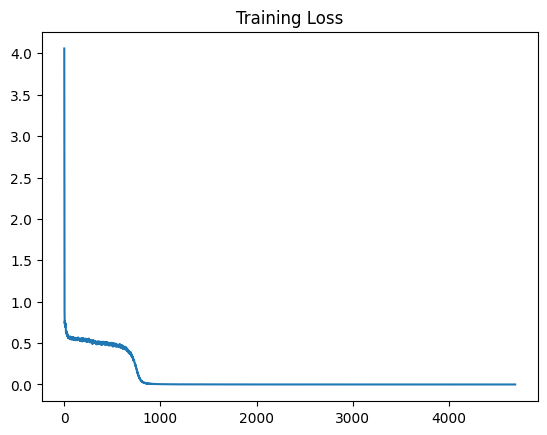

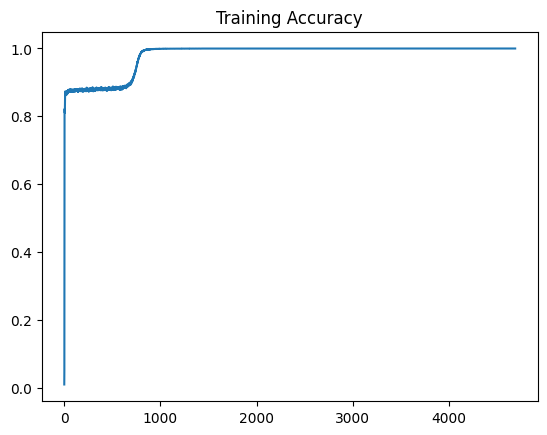

In [23]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

plt.plot(accuracies)
plt.title("Training Accuracy")
plt.show()

----
## <a name="4">Question 4: Transformer Inference (2.5 points total)</a>

Now that we've trained our model for next-token prediction, let's see if we can use it to generate MNIST images one token (pixel) at a time.

### 4.1: ArgMax Inference

**YOUR TASK (1 point)**: Fill in the commented portion of the `inference_argmax` code below to complete the autoregressive generation loop, and generate __two__ example images by running the cell.

  5%|▌         | 41/784 [00:00<00:03, 201.04it/s]

tensor([[ 5.0605,  5.5012,  7.1109, -8.7053, -4.3566,  1.0463,  0.5057,  2.4079,
         -4.5772, -8.2182,  4.5660, -1.6912, -3.7835,  1.9757,  6.3981,  0.1015,
          1.4146]], device='cuda:0')
[[2]]
tensor([[  5.6020,   2.1010,  21.9845, -15.6328,   2.8528,   4.0102,   3.3484,
           1.8493,  -2.1471,  -3.5979,  -0.3977,   0.7806,  -4.0599,   2.6214,
           3.7003,  -4.4621,   0.4865]], device='cuda:0')
[[2]]
tensor([[  6.2075,   1.7207,  22.0533, -15.7255,   3.8557,   2.8200,   3.6365,
           1.5699,  -2.9457,  -3.6920,  -0.3588,   1.4070,  -3.2386,   3.2616,
           2.3577,  -4.4754,   0.3571]], device='cuda:0')
[[2]]
tensor([[  6.2835,   1.8633,  21.2844, -15.1128,   4.2952,   2.1462,   3.6628,
           1.0810,  -3.2561,  -3.7417,  -0.1271,   1.7041,  -2.3317,   3.2507,
           1.8266,  -4.5518,   0.1831]], device='cuda:0')
[[2]]
tensor([[  6.2714,   2.0179,  20.6760, -14.2319,   4.0972,   2.2122,   3.2671,
           0.6523,  -2.7903,  -3.3473,  -0.2824,  

  8%|▊         | 62/784 [00:00<00:03, 199.25it/s]

tensor([[  4.6470,   1.4889,  21.3449, -12.7826,   2.1028,   1.9967,   1.4972,
           0.3292,  -1.2909,  -0.3639,  -2.9064,   4.1558,  -3.8450,   2.0035,
           4.4619,  -3.4948,  -1.0345]], device='cuda:0')
[[2]]
tensor([[  4.4564,   1.8447,  21.0402, -12.6322,   2.0603,   2.0880,   1.6540,
           0.1540,  -0.9843,  -0.4973,  -2.7319,   4.2377,  -3.8878,   2.0402,
           4.9007,  -3.5443,  -1.1677]], device='cuda:0')
[[2]]
tensor([[  4.5415,   2.0301,  20.6337, -12.8042,   2.1513,   1.9227,   1.9235,
           0.0459,  -1.0537,  -0.7248,  -2.5449,   4.3448,  -3.8936,   2.2093,
           5.1076,  -3.5877,  -1.3967]], device='cuda:0')
[[2]]
tensor([[  4.7461,   1.7148,  20.1599, -13.1434,   2.4302,   1.3798,   2.1499,
          -0.0262,  -1.4149,  -0.7438,  -2.4636,   4.6129,  -3.7225,   2.5049,
           4.9083,  -3.5054,  -1.7600]], device='cuda:0')
[[2]]
tensor([[  4.6507,   1.2013,  19.9770, -13.4798,   2.4240,   0.7960,   2.1823,
          -0.0477,  -1.5930,  -0.

 13%|█▎        | 104/784 [00:00<00:03, 200.21it/s]

tensor([[ 4.7758e+00,  8.8031e-01,  2.0831e+01, -1.2786e+01,  3.4435e+00,
         -1.0998e-01,  1.5030e+00, -7.2434e-01, -1.2513e+00, -4.4757e-03,
         -4.2673e+00,  6.0907e+00, -1.4730e+00,  1.6266e+00,  3.3615e+00,
         -3.3019e+00, -1.0711e+00]], device='cuda:0')
[[2]]
tensor([[  4.8353,   0.8092,  20.4742, -12.4737,   3.3512,  -0.3823,   0.9910,
          -0.9706,  -0.8753,   0.1740,  -4.3624,   6.3050,  -2.0982,   1.5460,
           3.4806,  -3.1298,  -1.2892]], device='cuda:0')
[[2]]
tensor([[  4.5552,   1.0424,  20.7309, -12.3886,   3.0148,  -0.9133,   0.5891,
          -1.3955,  -0.4379,   0.6741,  -4.8134,   7.2857,  -2.6122,   1.4175,
           3.9645,  -3.0061,  -1.3980]], device='cuda:0')
[[2]]
tensor([[  3.9548,   1.3683,  21.4707, -12.5204,   2.6384,  -1.3676,   0.4517,
          -1.7486,  -0.0250,   1.3837,  -5.5006,   8.5250,  -2.8531,   1.2949,
           4.4931,  -2.9323,  -1.4574]], device='cuda:0')
[[2]]
tensor([[  3.2453,   1.6502,  22.0475, -12.5891,   2

 19%|█▊        | 146/784 [00:00<00:03, 200.65it/s]

tensor([[  4.6469,   1.5795,  20.5018, -13.0054,   3.8065,  -1.7969,  -0.4774,
          -1.5522,  -0.2317,   0.4439,  -4.1902,   7.5211,  -2.3951,   1.9643,
           3.5150,  -4.1967,  -1.8305]], device='cuda:0')
[[2]]
tensor([[ 4.8183e+00,  1.1990e+00,  2.0763e+01, -1.3435e+01,  3.9898e+00,
         -1.9955e+00, -1.1960e+00, -1.2782e+00, -9.7272e-03,  9.0007e-01,
         -4.7629e+00,  7.6799e+00, -2.2387e+00,  2.4543e+00,  3.2747e+00,
         -4.1235e+00, -1.9282e+00]], device='cuda:0')
[[2]]
tensor([[  4.3096,   0.9764,  21.0629, -13.5487,   3.4181,  -2.3748,  -1.3719,
          -0.5047,  -0.0674,   1.3758,  -5.1747,   7.8614,  -2.0718,   3.1503,
           3.4533,  -3.9510,  -1.9259]], device='cuda:0')
[[2]]
tensor([[  3.6406,   1.1510,  20.8477, -12.8475,   1.9484,  -2.4334,  -0.5861,
           0.3826,  -0.6988,   1.3572,  -4.9299,   7.4644,  -1.9095,   3.0820,
           4.1786,  -3.6548,  -1.7977]], device='cuda:0')
[[2]]
tensor([[  4.3891,   0.8675,  21.0658, -12.4696,   2

 24%|██▍       | 188/784 [00:00<00:02, 200.73it/s]

tensor([[  6.1198,   1.2147,  21.7314, -13.0980,   3.2897,  -0.1835,  -0.4226,
          -1.4150,   0.4589,   1.4209,  -4.7932,   7.4052,  -4.0514,   0.4075,
           3.7596,  -4.8390,  -1.7941]], device='cuda:0')
[[2]]
tensor([[  5.0079,   1.6163,  21.5635, -12.5009,   2.4735,  -0.4793,   0.0412,
          -1.1037,  -0.3322,   1.2260,  -4.7556,   7.5659,  -3.4922,   0.6006,
           3.6326,  -4.2174,  -1.3311]], device='cuda:0')
[[2]]
tensor([[  4.6697,   2.0982,  20.7317, -12.0614,   2.2939,  -0.6775,   0.6177,
          -0.8509,  -1.0876,   0.5855,  -4.2990,   7.2999,  -3.0176,   1.2026,
           3.2317,  -3.9762,  -1.1448]], device='cuda:0')
[[2]]
tensor([[  4.5790,   2.2238,  20.0655, -11.9521,   2.6149,  -0.7752,   1.0435,
          -0.6924,  -1.5311,   0.1200,  -3.9166,   6.9528,  -2.5548,   1.8629,
           2.7405,  -3.8232,  -1.2546]], device='cuda:0')
[[2]]
tensor([[  4.6110,   1.8829,  19.4193, -11.9298,   3.3004,  -1.3107,   1.0403,
          -0.6653,  -1.6542,   0.

 29%|██▉       | 230/784 [00:01<00:02, 200.14it/s]

tensor([[  6.6923,   1.5733,  22.1662, -13.9959,   4.3452,   0.6785,   1.2599,
          -0.1168,  -1.1337,  -0.0920,  -4.0385,   5.0842,  -1.5352,   1.5658,
           1.6443,  -5.8265,  -0.9820]], device='cuda:0')
[[2]]
tensor([[  6.5351,   2.3482,  21.8139, -13.7391,   3.8595,   0.6104,   0.9349,
          -0.2786,  -0.8821,  -0.8791,  -3.6917,   5.1596,  -1.4247,   1.5430,
           2.3240,  -5.6784,  -1.0588]], device='cuda:0')
[[2]]
tensor([[  6.2177,   2.7443,  21.7002, -13.4662,   3.3002,   0.4753,   0.6178,
          -0.5117,  -0.4108,  -1.1327,  -3.6106,   5.5404,  -1.9981,   1.5048,
           3.3567,  -5.3709,  -1.2273]], device='cuda:0')
[[2]]
tensor([[  6.2600,   2.5859,  21.8970, -13.5351,   3.1344,   0.3678,   0.5602,
          -0.8638,  -0.1696,  -0.9452,  -3.6421,   5.9132,  -2.7792,   1.3225,
           3.9699,  -5.1572,  -1.2650]], device='cuda:0')
[[2]]
tensor([[  6.5451,   2.2690,  22.3038, -13.9209,   3.1684,   0.1922,   0.7647,
          -1.0082,  -0.4277,  -0.

 35%|███▍      | 272/784 [00:01<00:02, 199.67it/s]

tensor([[  6.1439,   1.5007,  21.3611, -12.2114,   1.8856,  -1.7210,   1.6766,
           0.6851,  -1.5857,   1.2084,  -4.5676,   6.5538,  -1.7184,   1.3211,
           2.7317,  -3.6788,  -0.8640]], device='cuda:0')
[[2]]
tensor([[  6.6777,   1.5140,  21.2011, -12.0135,   2.7263,  -1.1066,   1.6617,
           0.4204,  -1.2325,   0.7902,  -4.4515,   6.2083,  -1.7728,   0.9031,
           2.1581,  -3.7843,  -0.5876]], device='cuda:0')
[[2]]
tensor([[  6.9852,   1.6941,  20.7274, -11.9303,   3.3206,  -0.9229,   1.1366,
          -0.1751,  -0.7564,   0.4024,  -4.5465,   6.3362,  -1.9264,   0.5739,
           1.9380,  -3.6970,  -0.6113]], device='cuda:0')
[[2]]
tensor([[  6.8468,   1.9506,  20.2732, -11.9984,   3.5716,  -1.1631,   0.4059,
          -0.7697,  -0.2551,   0.3362,  -4.8282,   6.8439,  -2.1805,   0.5285,
           2.1324,  -3.5704,  -0.9775]], device='cuda:0')
[[2]]
tensor([[  6.2725,   2.1677,  20.5179, -12.3537,   3.4919,  -1.5947,  -0.3268,
          -1.1164,   0.2660,   0.

 40%|███▉      | 312/784 [00:01<00:02, 199.12it/s]

tensor([[  4.7929,   1.5173,  22.1314, -13.9957,   2.9754,  -1.7572,   0.6837,
          -0.2580,  -0.5776,   0.8255,  -5.2779,   7.4389,  -2.5312,   2.6270,
           3.5220,  -3.5810,  -1.9839]], device='cuda:0')
[[2]]
tensor([[  4.7961,   1.5419,  21.8959, -14.2487,   2.6544,  -2.0096,   0.8232,
          -0.6362,  -0.4611,   1.1268,  -5.2645,   7.7937,  -3.1545,   2.2465,
           4.0163,  -3.4307,  -2.2625]], device='cuda:0')
[[2]]
tensor([[  4.9552,   1.3749,  22.3354, -14.1775,   2.1728,  -2.1082,   0.6309,
          -0.3410,  -0.2216,   1.8499,  -5.9816,   8.0785,  -3.7521,   1.8519,
           4.3357,  -3.3022,  -2.3635]], device='cuda:0')
[[2]]
tensor([[  5.2534,   1.3746,  23.0924, -14.0541,   1.9983,  -1.7963,   0.0984,
           0.1712,  -0.0900,   2.0901,  -6.5486,   7.8945,  -3.8534,   1.4621,
           4.3326,  -3.4963,  -2.0096]], device='cuda:0')
[[2]]
tensor([[  5.3974,   1.3211,  23.4897, -13.8708,   2.2528,  -1.2354,  -0.3878,
           0.6176,  -0.1299,   1.

 45%|████▍     | 352/784 [00:01<00:02, 197.39it/s]

tensor([[  4.9192,   1.7771,  21.1036, -12.5115,   1.5980,  -0.2632,   0.5923,
          -0.6668,   0.4116,   0.6617,  -4.7101,   6.5298,  -4.3897,   1.7273,
           4.5610,  -3.0818,  -1.8057]], device='cuda:0')
[[2]]
tensor([[  4.8041,   1.4438,  21.5609, -13.0743,   1.6341,  -0.7353,   0.6220,
          -0.6314,   0.0836,   0.7912,  -5.0030,   6.9967,  -4.6244,   2.1285,
           4.3552,  -2.9039,  -1.6741]], device='cuda:0')
[[2]]
tensor([[  4.6897,   0.9259,  21.9811, -13.7623,   2.1071,  -1.7684,   0.6794,
          -0.7132,  -0.3158,   1.1684,  -5.4049,   7.8103,  -4.2035,   2.8226,
           3.7264,  -2.9003,  -1.5307]], device='cuda:0')
[[2]]
tensor([[  4.2623,  -0.0489,  22.0989, -13.9680,   2.3261,  -2.3132,   1.2350,
          -0.5508,  -0.1663,   2.6449,  -6.0835,   8.0455,  -3.6844,   3.3284,
           3.4654,  -3.0749,  -2.0031]], device='cuda:0')
[[2]]
tensor([[  3.9854,  -0.8828,  21.8854, -13.8059,   2.6218,  -2.5190,   2.1712,
          -0.5150,  -0.2207,   3.

 50%|█████     | 392/784 [00:01<00:01, 196.70it/s]

tensor([[  5.0022,   1.6084,  21.3409, -13.5160,   1.2705,  -3.1612,  -1.3810,
           0.4123,  -0.2485,   1.5894,  -6.4087,   8.3650,  -2.2982,   3.0120,
           5.2237,  -2.4012,  -1.8308]], device='cuda:0')
[[2]]
tensor([[  4.8540,   1.7867,  22.0255, -13.4292,   1.3305,  -3.0224,  -1.9367,
           0.5023,   0.1977,   1.9368,  -6.7216,   8.6579,  -2.4195,   3.1336,
           5.4469,  -2.8434,  -1.5925]], device='cuda:0')
[[2]]
tensor([[  4.7150,   1.8869,  22.4039, -13.1967,   1.4145,  -2.4924,  -1.6813,
           0.8103,   0.1594,   2.0462,  -6.4541,   8.2532,  -2.2361,   3.2282,
           5.2744,  -3.2536,  -1.3150]], device='cuda:0')
[[2]]
tensor([[  4.8454,   1.9366,  22.4326, -12.9992,   1.6154,  -2.0666,  -1.4539,
           1.2269,   0.0737,   1.7551,  -6.0905,   7.6171,  -1.8121,   3.2560,
           4.7829,  -3.4129,  -0.9816]], device='cuda:0')
[[2]]
tensor([[  5.1839,   2.0061,  22.2627, -12.9481,   2.1101,  -1.5747,  -1.1487,
           1.5456,  -0.0803,   0.

 55%|█████▌    | 433/784 [00:02<00:01, 197.40it/s]

tensor([[  5.6559,   1.4615,  23.0620, -12.4929,   3.0415,  -0.9034,  -0.2226,
          -0.1789,  -0.1090,   1.8249,  -5.7806,   7.4269,  -2.0809,   0.5964,
           2.5214,  -4.0708,  -0.1602]], device='cuda:0')
[[2]]
tensor([[  5.5268,   1.9314,  22.4661, -12.0060,   2.5712,  -0.8363,  -0.3500,
           0.1398,  -0.2924,   1.5961,  -5.7271,   7.0817,  -1.6202,   0.7396,
           2.5389,  -4.2708,  -0.2748]], device='cuda:0')
[[2]]
tensor([[  5.2791,   2.3184,  21.8833, -11.7038,   2.3592,  -0.9594,  -0.3554,
          -0.0752,  -0.3022,   1.5898,  -5.3431,   7.2611,  -1.7226,   1.1053,
           2.8186,  -4.4479,  -0.4636]], device='cuda:0')
[[2]]
tensor([[  5.2142,   2.5315,  21.7992, -11.7359,   2.7717,  -0.9045,  -0.1731,
          -0.3748,  -0.2473,   1.4550,  -4.8071,   7.2131,  -1.9286,   1.5026,
           2.9411,  -4.7418,  -0.5639]], device='cuda:0')
[[2]]
tensor([[  5.2178,   2.6903,  22.0448, -11.7370,   3.5933,  -0.9011,  -0.4702,
          -0.5009,   0.1043,   1.

 60%|██████    | 473/784 [00:02<00:01, 193.37it/s]

tensor([[  5.0450,   1.4422,  20.7956, -12.9293,   3.4972,  -2.0845,  -1.6414,
          -0.8010,  -0.4934,   0.8230,  -4.2378,   7.1434,  -1.2058,   2.0893,
           3.2235,  -4.5897,  -0.5821]], device='cuda:0')
[[2]]
tensor([[  5.2478,   1.2097,  20.8956, -12.7071,   3.6779,  -1.6619,  -1.3569,
          -0.6354,  -0.6989,   0.4220,  -3.8053,   6.7241,  -0.8814,   1.9526,
           2.7487,  -4.5099,  -0.0386]], device='cuda:0')
[[2]]
tensor([[  5.1692,   0.9535,  20.9313, -12.4691,   3.9166,  -1.2280,  -0.9792,
          -0.9307,  -0.3851,   0.6740,  -3.9549,   6.6933,  -1.0123,   1.9161,
           2.4978,  -4.2015,   0.0690]], device='cuda:0')
[[2]]
tensor([[  5.3802,   1.1384,  20.5641, -12.2716,   3.8802,  -0.9023,  -0.7337,
          -1.1994,  -0.3104,   0.4115,  -3.8128,   6.3806,  -1.2163,   1.8203,
           2.5895,  -4.1375,   0.0566]], device='cuda:0')
[[2]]
tensor([[  5.5701,   1.4868,  19.3945, -11.9304,   3.5405,  -0.5726,  -0.9918,
          -1.1919,  -0.4423,  -0.

 65%|██████▌   | 513/784 [00:02<00:01, 191.60it/s]

tensor([[ 4.7825e+00,  1.1203e+00,  2.1822e+01, -1.2120e+01,  1.7782e+00,
         -6.1721e-01, -9.9763e-01,  1.3258e-01, -5.9821e-01,  1.1533e+00,
         -4.8190e+00,  6.4551e+00, -2.6601e+00,  1.7648e+00,  3.9046e+00,
         -3.5944e+00, -2.9962e-03]], device='cuda:0')
[[2]]
tensor([[  4.8263,   1.7844,  22.0761, -11.7217,   1.6988,  -0.7147,  -0.6185,
           0.4097,  -0.9410,   0.8808,  -4.7081,   6.6153,  -2.8399,   2.2240,
           3.6806,  -3.8633,   0.2956]], device='cuda:0')
[[2]]
tensor([[  5.1274,   1.9121,  21.9948, -11.6139,   2.2220,  -0.5167,   0.1285,
           0.0959,  -1.1584,   0.7034,  -4.3575,   6.5101,  -2.7202,   2.2260,
           3.0272,  -4.0506,   0.3299]], device='cuda:0')
[[2]]
tensor([[  5.4747,   1.8987,  21.7580, -11.7718,   2.8906,  -0.5684,   0.6336,
          -0.3130,  -1.1645,   0.6329,  -4.2338,   6.4861,  -2.3674,   2.3260,
           2.3992,  -4.1794,   0.0543]], device='cuda:0')
[[2]]
tensor([[  5.7753,   2.0704,  21.3899, -11.9518,   3

 71%|███████   | 553/784 [00:02<00:01, 192.42it/s]

tensor([[  5.8960,   1.2722,  23.0377, -13.2540,   2.3879,  -1.4579,  -0.6183,
           1.2718,  -1.2857,   1.3247,  -5.4060,   6.2428,  -1.1262,   2.0809,
           3.7008,  -4.4556,  -0.8986]], device='cuda:0')
[[2]]
tensor([[ 5.8731e+00,  1.2533e+00,  2.3035e+01, -1.3191e+01,  2.2350e+00,
         -1.4004e+00, -1.0327e-02,  1.3819e+00, -1.8126e+00,  1.3964e+00,
         -5.1672e+00,  6.0799e+00, -5.1181e-01,  2.1436e+00,  3.5487e+00,
         -4.6836e+00, -9.4234e-01]], device='cuda:0')
[[2]]
tensor([[  5.4076,   1.1667,  22.5842, -12.7658,   2.2449,  -1.3280,   0.1880,
           1.0524,  -1.6362,   1.7660,  -4.9295,   6.1345,  -0.4409,   2.2339,
           3.6974,  -4.5520,  -1.2022]], device='cuda:0')
[[2]]
tensor([[  5.1187,   1.3690,  21.6223, -12.2539,   2.4781,  -1.2429,  -0.0436,
           0.3420,  -1.1366,   1.7414,  -4.4348,   6.2809,  -0.8349,   2.1881,
           3.9684,  -4.3767,  -1.2696]], device='cuda:0')
[[2]]
tensor([[ 5.2238e+00,  1.3235e+00,  2.0800e+01, -1.1

 76%|███████▌  | 593/784 [00:03<00:00, 192.60it/s]

tensor([[  5.3318,   0.2382,  20.9677, -12.2744,   4.2057,  -1.6872,  -0.7603,
          -0.3763,  -0.0380,   2.1124,  -5.0961,   7.0508,  -2.2475,   2.4953,
           2.2765,  -3.7512,  -0.8604]], device='cuda:0')
[[2]]
tensor([[  5.0427,   0.6353,  20.7895, -12.0024,   3.9062,  -1.3317,  -0.3332,
          -0.1602,  -0.2493,   1.5686,  -4.5725,   6.6100,  -2.0737,   2.7048,
           2.3001,  -3.8088,  -0.4999]], device='cuda:0')
[[2]]
tensor([[  4.9601,   0.9159,  20.5863, -11.8546,   3.7985,  -0.9799,  -0.0351,
          -0.1642,  -0.2705,   1.1265,  -4.2491,   6.3209,  -2.0405,   2.7020,
           2.2707,  -3.7584,  -0.3425]], device='cuda:0')
[[2]]
tensor([[  5.1674,   1.1431,  20.6196, -11.9864,   3.9480,  -0.6269,   0.1266,
          -0.3914,  -0.2224,   0.7980,  -4.1694,   6.1830,  -2.0351,   2.3267,
           2.2223,  -3.8483,  -0.4494]], device='cuda:0')
[[2]]
tensor([[  5.1944,   1.1490,  20.2850, -11.9684,   4.1823,  -0.3235,   0.1563,
          -0.7101,  -0.2370,   0.

 81%|████████  | 633/784 [00:03<00:00, 191.95it/s]

tensor([[  4.4794,   0.9904,  21.1676, -12.6632,   1.7638,  -0.9568,  -1.0079,
           0.6614,  -0.8777,   1.3212,  -5.0953,   6.2452,  -1.9611,   2.1571,
           3.9560,  -4.3919,  -1.1418]], device='cuda:0')
[[2]]
tensor([[  4.6824,   1.0519,  21.0711, -12.5376,   1.7161,  -0.4888,  -0.6021,
           1.0009,  -1.1041,   1.0069,  -4.6583,   5.6917,  -1.6757,   2.2180,
           3.7625,  -4.4351,  -1.1249]], device='cuda:0')
[[2]]
tensor([[  5.0656,   0.8315,  20.7021, -12.5818,   2.1489,  -0.6756,  -0.3041,
           0.9400,  -1.2242,   0.7776,  -4.2693,   5.6890,  -1.6360,   2.5762,
           3.3748,  -4.2755,  -1.2292]], device='cuda:0')
[[2]]
tensor([[  5.2324,   0.6686,  19.7280, -12.4530,   2.7561,  -1.0797,  -0.2706,
           0.2977,  -1.1319,   0.3670,  -3.7719,   5.8450,  -1.6426,   2.7591,
           3.0761,  -3.8769,  -1.2333]], device='cuda:0')
[[2]]
tensor([[  5.0420,   0.4987,  18.6220, -12.1893,   2.9273,  -1.4434,  -0.4445,
          -0.2994,  -0.8905,   0.

 86%|████████▌ | 673/784 [00:03<00:00, 193.39it/s]

tensor([[ 4.9330e+00,  6.8439e-01,  2.0853e+01, -1.2500e+01,  2.6283e+00,
         -1.5756e+00, -1.0849e-01, -1.8953e-01,  6.8161e-03,  1.7006e+00,
         -4.9906e+00,  7.3509e+00, -1.4073e+00,  2.1935e+00,  4.1455e+00,
         -3.7955e+00, -3.1548e-01]], device='cuda:0')
[[2]]
tensor([[  5.1598,   0.8662,  20.4508, -12.2305,   2.5969,  -1.1723,   0.3611,
          -0.2402,  -0.4706,   1.3276,  -4.4805,   6.8318,  -1.1086,   1.8036,
           3.7798,  -3.9499,  -0.1028]], device='cuda:0')
[[2]]
tensor([[  5.4717,   1.0708,  20.1739, -11.9000,   2.6158,  -0.6722,   0.5022,
          -0.6291,  -0.5969,   1.0095,  -4.0849,   6.4540,  -1.2432,   1.2316,
           3.6184,  -4.0101,   0.0627]], device='cuda:0')
[[2]]
tensor([[  5.6261,   1.2478,  20.2391, -11.7827,   2.7685,  -0.1711,   0.5208,
          -1.0843,  -0.4918,   0.8327,  -3.9219,   6.3345,  -1.5794,   0.7580,
           3.5382,  -4.0222,   0.1015]], device='cuda:0')
[[2]]
tensor([[  5.5485,   1.3811,  20.6180, -12.0643,   2

 91%|█████████ | 713/784 [00:03<00:00, 193.01it/s]

tensor([[  5.2345,   1.4864,  20.7915, -11.4263,   2.9559,  -1.0963,   0.4231,
           0.9852,  -1.1384,   1.5044,  -3.8288,   5.8066,  -1.5855,   1.9971,
           1.9028,  -4.5244,  -0.6812]], device='cuda:0')
[[2]]
tensor([[  5.0232,   1.7527,  21.0324, -11.5964,   3.3381,  -1.0370,   0.7987,
           0.5138,  -0.9618,   1.3099,  -3.6821,   6.2702,  -1.6035,   1.9516,
           1.9943,  -4.4863,  -0.6364]], device='cuda:0')
[[2]]
tensor([[  4.7951,   1.9031,  20.9032, -11.9159,   3.7305,  -1.0839,   1.0022,
          -0.0481,  -0.6427,   1.2600,  -3.7202,   6.7482,  -1.6514,   1.8861,
           2.1738,  -4.4164,  -0.9497]], device='cuda:0')
[[2]]
tensor([[  4.8041,   1.7962,  20.3091, -12.1441,   4.1928,  -1.1018,   0.6709,
          -0.3781,  -0.2757,   1.1470,  -3.8331,   6.6951,  -1.6202,   1.8370,
           2.0007,  -4.2760,  -1.3168]], device='cuda:0')
[[2]]
tensor([[ 5.0283e+00,  1.6543e+00,  1.9654e+01, -1.2341e+01,  4.3586e+00,
         -1.3447e+00, -1.3163e-01, -5.

 96%|█████████▌| 753/784 [00:03<00:00, 193.48it/s]

tensor([[ 4.6311e+00,  9.6718e-01,  2.0703e+01, -1.2031e+01,  3.6505e+00,
         -1.2371e+00,  2.6091e-01, -8.0544e-01, -9.7242e-01,  8.0319e-01,
         -3.7502e+00,  5.8763e+00, -1.5289e+00,  2.2993e+00,  2.6688e+00,
         -3.9962e+00,  2.0174e-02]], device='cuda:0')
[[2]]
tensor([[  5.0675,   1.2911,  19.8336, -11.7627,   4.0618,  -0.9899,   0.2988,
          -1.7081,  -0.8176,   0.4213,  -3.2107,   5.5562,  -1.6300,   1.7004,
           2.4658,  -3.9838,  -0.1145]], device='cuda:0')
[[2]]
tensor([[  5.2809,   1.5526,  19.3166, -11.5505,   4.0001,  -0.9737,   0.1032,
          -2.0453,  -0.7484,   0.1189,  -2.8388,   5.3987,  -1.9278,   1.1823,
           2.6365,  -3.9890,  -0.2606]], device='cuda:0')
[[2]]
tensor([[ 5.2634e+00,  1.6460e+00,  1.9354e+01, -1.1534e+01,  3.8485e+00,
         -1.1012e+00, -1.2656e-01, -2.0329e+00, -6.7488e-01,  1.7962e-02,
         -2.8342e+00,  5.5818e+00, -2.4264e+00,  1.0186e+00,  2.8045e+00,
         -3.9408e+00, -2.7492e-01]], device='cuda:0'

100%|██████████| 784/784 [00:04<00:00, 195.81it/s]


tensor([[  4.6939,   1.6548,  19.3178, -11.3801,   4.2419,  -2.6798,  -0.0928,
          -1.4269,  -0.1924,   1.2490,  -3.7877,   7.5399,  -0.7069,   1.8332,
           2.3555,  -4.7872,  -1.2636]], device='cuda:0')
[[2]]
tensor([[  4.6367,   2.1041,  19.1661, -11.1160,   3.8867,  -2.1790,  -0.6233,
          -1.2915,   0.1370,   0.5254,  -3.3713,   7.2180,  -0.9651,   1.6811,
           3.0903,  -4.8387,  -1.2448]], device='cuda:0')
[[2]]
tensor([[  4.9272,   2.2465,  19.3034, -11.2648,   3.6060,  -1.7349,  -0.5668,
          -1.0458,   0.1785,   0.0215,  -3.1782,   6.9463,  -1.5709,   1.6249,
           3.5328,  -4.8271,  -1.0337]], device='cuda:0')
[[2]]
tensor([[  5.1941,   2.0957,  19.5755, -11.5924,   3.5248,  -1.7139,  -0.5354,
          -0.7786,   0.0666,  -0.1680,  -3.4213,   6.9141,  -1.9177,   1.7006,
           3.5923,  -4.6022,  -0.8203]], device='cuda:0')
[[2]]
tensor([[  5.2541,   1.9409,  20.2578, -12.0348,   3.3010,  -1.7261,  -0.8546,
          -0.2427,  -0.1705,  -0.

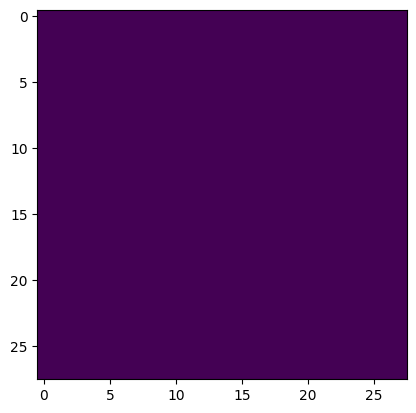

In [61]:
@torch.no_grad()
def inference_argmax(
  m: TransformerDecoder,
  x: torch.Tensor = None,
  max_length: int = 784,
):
  m.eval()

  # start with a partial sequence; if no partial sequence is
  # given, start with only the "start" token
  if x is None:
    x = torch.full((1, 1), VOCAB_SIZE)
  else:
    assert x.ndim == 2
    assert x.shape[0] == 1

  seq_len = x.shape[1]

  remaining = max_length - seq_len + 1# account for "start" token

  x = x.to(device)

  for i in tqdm(range(remaining)):

    out = m(x)  # (n_batch, partial_seq_len, vocab_size)

    ########################################
    # YOUR CODE HERE: complete the argmax inference
    # loop by doing the following
    #
    # 1. Select the logits for the last
    #    sequence step in our transformer's
    #    output
    # 2. Take the argmax over the vocabulary
    #    dimension of these logits to sample
    #    an integer token
    # 3. Append this sampled token to our
    #    input x
    ########################################

    # 1. Select logits for last step
    last_logits = out[:, -1, :]  # (batch_size=1, vocab_size)
    print(last_logits)

    # 2. Take argmax to sample token
    next_token = torch.argmax(last_logits, dim=-1, keepdim=True)  # (batch_size=1, 1)
    print(next_token.cpu().numpy())

    # 3. Append sampled token to input
    x = torch.cat([x, next_token], dim=1)  # Extend sequence


  return x[:, 1:]


out = inference_argmax(tf)

plt.imshow(out.reshape(28, 28).cpu().detach())
plt.show()

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR TWO IMAGES HERE)</div>
</center>

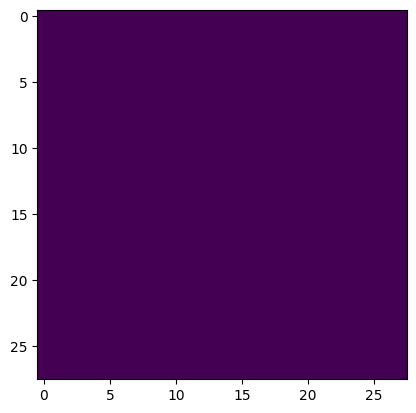

In [ ]:
print(out.cpu().numpy().reshape(28, 28))

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

No clue why token 2 is always picked...

### 4.2: Multinomial Inference

**YOUR TASK (1 point)**: Complete the `inference_multinomial` code below to apply random multinomial sampling rather than argmax sampling of each token in the autoregressive generation loop, using `torch.multinomial`. Generate __two__ example images by running the cell.


100%|██████████| 784/784 [00:06<00:00, 125.06it/s]


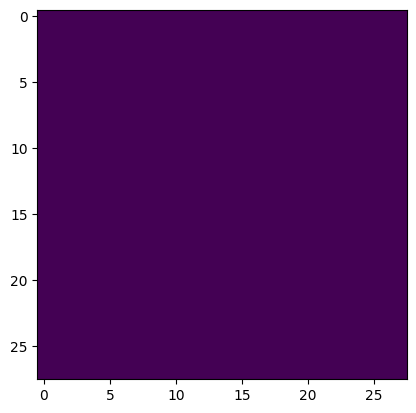

In [62]:
@torch.no_grad()
def inference_multinomial(
  m: TransformerDecoder,
  x: torch.Tensor = None,
  max_length: int = 784,
):
  m.eval()

  # start with a partial sequence; if no partial sequence is
  # given, start with only the "start" token
  if x is None:
    x = torch.full((1, 1), VOCAB_SIZE)
  else:
    assert x.ndim == 2
    assert x.shape[0] == 1

  seq_len = x.shape[1]

  remaining = max_length - seq_len + 1  # account for "start" token

  x = x.to(device)

  for i in tqdm(range(remaining)):

    out = m(x)  # (n_batch, partial_seq_len, vocab_size)

    ########################################
    # YOUR CODE HERE: complete the multinomial
    # inference loop by doing the following
    #
    # 1. Select the logits for the last
    #    sequence step in our transformer's
    #    output
    # 2. Apply softmax along the vocabulary
    #    dimension to convert logits to
    #    token probabilities
    # 3. Sample an integer index (token)
    #    from these probabilities using
    #    `torch.multinomial`
    # 4. Append this sampled token to our
    #    input x
    ########################################

    # 1. Select logits for last step
    out = m(x)  # (n_batch, partial_seq_len, vocab_size)
    last_logits = out[:, -1, :]  # Get the last time step logits

    # 2. Apply softmax along vocabulary dimension
    probabilities = torch.softmax(last_logits, dim=-1)

    # 3. Use `torch.multinomial` to sample token
    sampled_token = torch.multinomial(probabilities, num_samples=1)  # Shape: (1, 1)

    # 3. Append sampled token to input
    x = torch.cat([x, sampled_token], dim=1)

  return x[:, 1:]


out = inference_multinomial(tf)

plt.imshow(out.reshape(28, 28).cpu().detach())
plt.show()

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR TWO IMAGES HERE)</div>
</center>

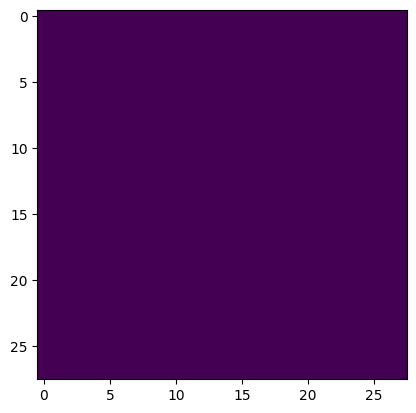

In [66]:
print(out.cpu().numpy().reshape(28, 28))

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

### 4.3: Argmax vs. Multinomial

**YOUR TASK (0.5 points)**: Explain whether you see any difference between the quality of outputs generated with argmax and multinomial sampling; if so, what might account for this difference?

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

----
## <a name="5">Question 5: Image Completion (2 points total)</a>

Finally, we'll explore how our "raster-order" autoregressive generation of pixels can be used to complete partial images.

### 5.1: Completing an 8

**YOUR TASK (1 point)**: Find an image of the digit `8` from the MNIST _validation_ set and trim rows from the bottom until only part of the "top circle" remains. Pass a corresponding token sequence to one of your two `inference` functions from Question 4 to generate the remainder of the image, and __provide one generation that looks like an 8, and one that looks like a 0__. Make sure you also plot the original 8, as well as the partial (trimmed) 8 on which completions are performed.



In [71]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load MNIST validation dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_val = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Function to find and trim an "8"
def get_partial_digit(digit=8, trim_rows=14):
    for img, label in mnist_val:
        if label == digit:
            img = img.squeeze(0)  # Convert (1,28,28) -> (28,28)
            original = img.clone()
            partial = img.clone()
            partial[trim_rows:, :] = 0  # Remove bottom rows
            return original, partial
    return None, None

# Display function
def plot_images(original, partial, completed_8, completed_0):
    fig, axes = plt.subplots(1, 4, figsize=(10, 4))
    titles = ["Original 8", "Trimmed 8", "Completed 8", "Completed 0"]
    images = [original, partial, completed_8, completed_0]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis("off")

    plt.show()


In [72]:
@torch.no_grad()
def inference_multinomial(
    m, x: torch.Tensor, max_length: int = 784, biased_zero=False
):
    """Performs multinomial inference for image completion"""
    m.eval()
    seq_len = x.shape[1]
    remaining = max_length - seq_len + 1  # account for "start" token
    x = x.to(device)

    for i in tqdm(range(remaining)):
        out = m(x)  # Model output (batch_size=1, seq_len, vocab_size)

        # 1. Select logits for last step
        last_logits = out[:, -1, :]

        # 2. Apply softmax to get probabilities
        probs = torch.softmax(last_logits, dim=-1)

        # 3. Modify probabilities for "0"-like completion
        if biased_zero:
            probs[:, 2] += 0.2  # Slightly increase the probability of token "2"
            probs /= probs.sum(dim=-1, keepdim=True)

        # 4. Sample token using `torch.multinomial`
        next_token = torch.multinomial(probs, num_samples=1)

        # 5. Append sampled token to sequence
        x = torch.cat([x, next_token], dim=1)

    return x[:, 1:]
